In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import fairseq
from models.wav2vec_u import Wav2vec_U as w2vu
from models.wav2dyn_gpt import Wav2vec_U as w2vuindy
import torch.nn.functional as F
import math
import seaborn as sns
from tqdm.notebook import tqdm
import random

2023-05-11 06:38:56.617963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 06:38:59.235503: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/lmod/mpi/libfabric/1.17.1/lib:/opt/ohpc/pub/mpi/ucx-ohpc/1.11.2/lib:/opt/ohpc/pub/libs/hwloc/lib:/opt/ohpc/pub/mpi/openmpi4-gnu9/4.1.1/lib:/opt/ohpc/pub/compiler/gcc/9.4.0/lib64
2023-05-11 06:38:59.235630: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

In [2]:
val_feats = np.load("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.npy")

In [3]:
with open("/home/santiago.cuervo/ssl/nanoGPT/data/wiki40b_phn/en/input.txt", "r") as f:
    wiki_transcripts = f.readlines()

In [6]:
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.tsv", "r") as f:
    lines = f.readlines()
audio_path = lines[0]
audio_ids = []
for audio_id in lines[1:]:
    audio_ids.append(audio_id.split('\t')[0].split('/')[1])
    
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.phn", "r") as f:
    phone_transcripts = f.readlines()
    
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.lengths", "r") as f:
    seq_lens = f.readlines()
seq_lens = [int(l) for l in seq_lens]

In [7]:
dataset = np.split(val_feats, np.cumsum(seq_lens)[:-1])

In [8]:
len(audio_ids), len(phone_transcripts), len(seq_lens), len(dataset)

(2864, 2864, 2864, 2864)

Text(0.5, 1.0, 'Wav2vec representations for sample 3660-172183-0024.wav')

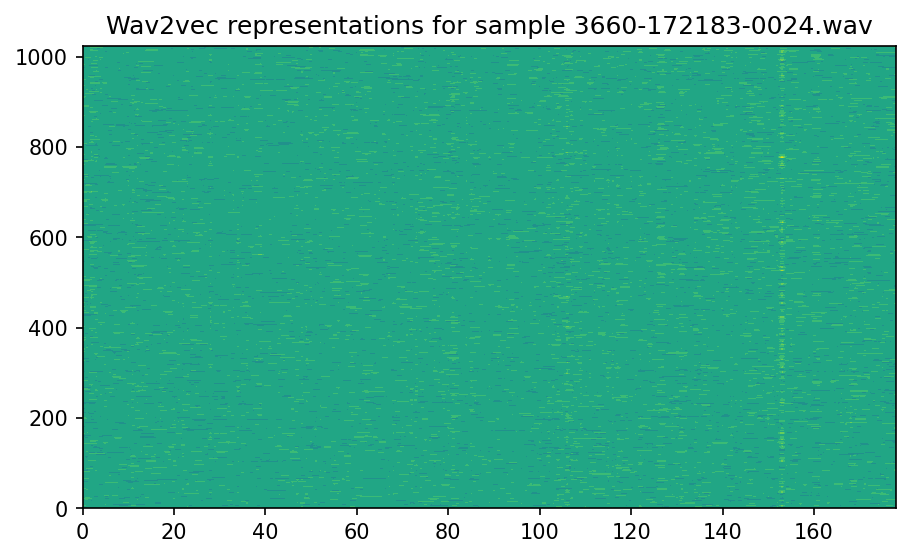

In [9]:
sample_idx = 1
x = np.arange(0, seq_lens[sample_idx])
y = np.arange(0, val_feats.shape[1])
X, Y = np.meshgrid(x, y)
Z = dataset[sample_idx].T
Z = Z / np.sqrt((Z**2).sum(1, keepdims=True))

plt.figure(figsize=(7, 4), dpi=150)
plt.contourf(X, Y, Z, 10)
plt.title(f"Wav2vec representations for sample {audio_ids[sample_idx]}")

In [10]:
# cp = '/multirun/2023-05-07/12-23-39/0/w2v2_2023-05-07_12:21:11_0/checkpoint_12_2000.pt'
cp = '/multirun/2023-05-04/07-33-47/0/w2v2_2023-05-04_07:33:02_2/checkpoint_best.pt'

model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp])
wav2phn = model[0]
wav2phn.eval()

Wav2vec_U(
  (discriminator): Discriminator(
    (net): Sequential(
      (0): Conv1d(44, 384, kernel_size=(8,), stride=(1,), padding=(7,))
      (1): SamePad()
      (2): Dropout(p=0.0, inplace=False)
      (3): Sequential(
        (0): Conv1d(384, 384, kernel_size=(8,), stride=(1,), padding=(7,))
        (1): SamePad()
        (2): Dropout(p=0.0, inplace=False)
        (3): GELU(approximate='none')
      )
      (4): Conv1d(384, 1, kernel_size=(8,), stride=(1,), padding=(7,))
      (5): SamePad()
    )
  )
  (segmenter): JoinSegmenter()
  (generator): Generator(
    (dropout): Dropout(p=0.1, inplace=False)
    (proj): Sequential(
      (0): TransposeLast()
      (1): Conv1d(1024, 44, kernel_size=(9,), stride=(3,), padding=(4,), bias=False)
      (2): TransposeLast()
    )
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (in_proj): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (decoder): Linear(in_features=1024, out_feature

In [19]:
# cp = '/multirun/2023-05-05/22-24-16/0/w2v-indy-phn_en-phn_en_2023-05-05_22:24:05_0/checkpoint_best.pt'
# cp = '/multirun/2023-05-08/21-38-04/0/w2v-indy-phn_en-phn_en_2023-05-08_21:37:03_0/checkpoint_best.pt'
# cp = '/multirun/2023-05-11/04-35-56/0/w2v-indy-phn_en-phn_en_2023-05-11_04:35:27_0/checkpoint_best.pt'
cp = '/home/santiago.cuervo/multirun/2023-05-10/18-34-54/0/w2v-indy-phn_en-phn_en_2023-05-10_18:34:45/checkpoint_best.pt'

model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp])
wav2dyn = model[0]
wav2dyn.eval()

LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


Wav2vec_U(
  (segmenter): JoinSegmenter()
  (lm): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(44, 384)
      (wpe): Embedding(256, 384)
      (drop): Dropout(p=0.2, inplace=False)
      (h): ModuleList(
        (0-2): 3 x Block(
          (ln_1): LayerNorm()
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=384, out_features=1152, bias=False)
            (c_proj): Linear(in_features=384, out_features=384, bias=False)
            (attn_dropout): Dropout(p=0.2, inplace=False)
            (resid_dropout): Dropout(p=0.2, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=384, out_features=1536, bias=False)
            (c_proj): Linear(in_features=1536, out_features=384, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm()
    )
    (lm_head): Linear(in_features=384, out_features=44, bias=False)
  )
  (discriminat

# wav2phn outs

Utterance:
AH N D DH OW DH AW SH OW L D AH S T D IH Z AY ER T UW S IY M AY D IH F IY T AH N D M AY D EH TH B AY DH AH HH AE N D Z AH V DH OW Z M EH N Y EH T D UW AY F IY L N OW D R EH D

Predicted:
AH D DH OW DH AW SH UH D S T IH Z AY ER T UW S IY M AY D IH F IY T IH N M AY D EH TH B AY DH AH HH AE N Z AH V OW Z M EH N D AH N T S Y EH T D UW AY F IY L N OW D R EH D


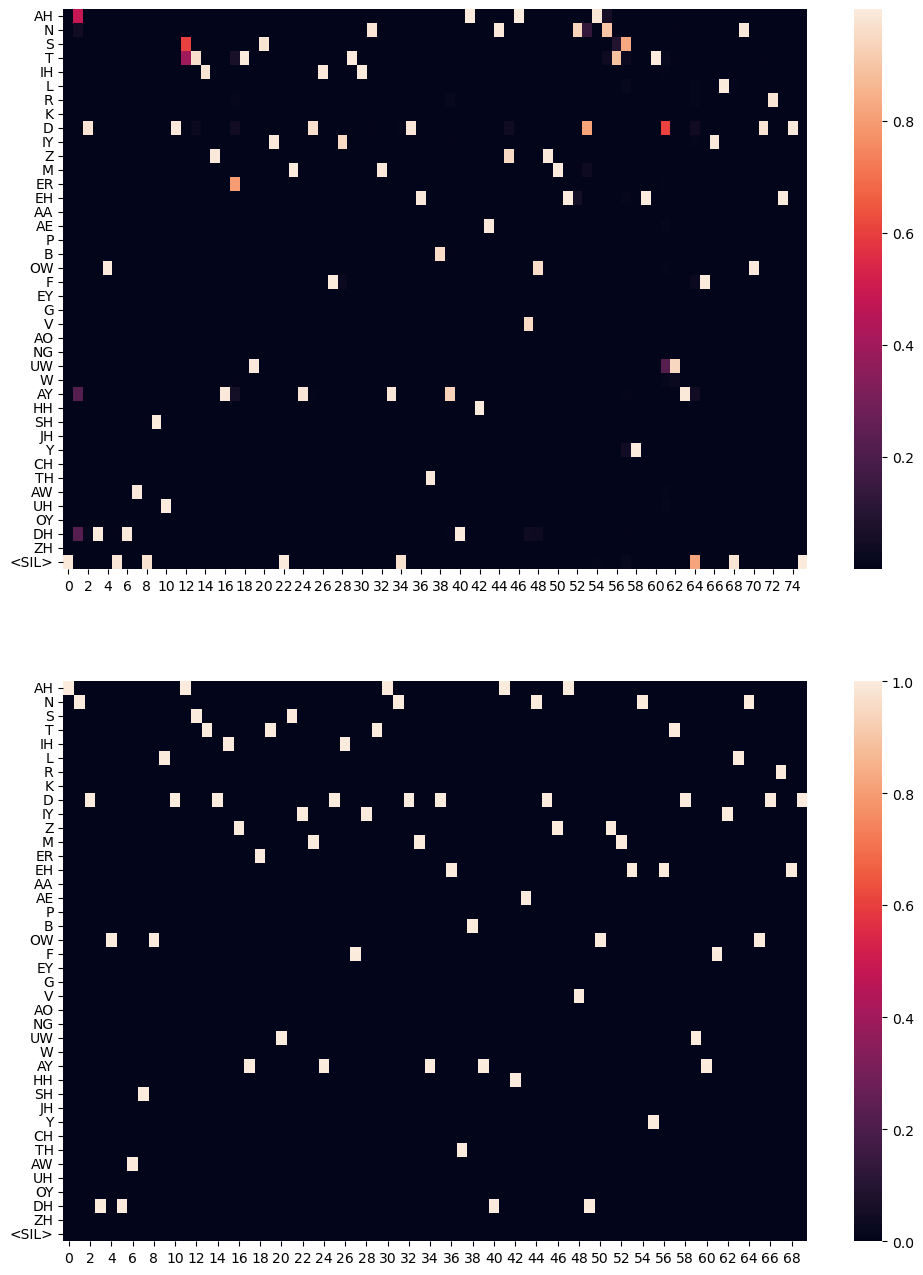

In [12]:
sample_idx = 0
x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
gen_result = wav2phn(x, padding_mask, dense_x_only=True)
dense_x = gen_result['logits'][:, :, 4:].squeeze().detach().numpy().T
predicted_x = dense_x.argmax(0) + 4
predicted_x = predicted_x[predicted_x != task.sil_id]
token_x = task.target_dictionary.encode_line(phone_transcripts[sample_idx][:-1], append_eos=False).long() - 4
token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float().squeeze().detach().numpy().T
plt.figure(figsize=(12, 16))
plt.subplot(211)
sns.heatmap(dense_x, yticklabels=task.target_dictionary.symbols[4:])
plt.subplot(212)
sns.heatmap(token_x, yticklabels=task.target_dictionary.symbols[4:])
print(f"Utterance:\n{phone_transcripts[sample_idx]}")
print(f"Predicted:\n{task.target_dictionary.string(predicted_x)}")

Now LM posteriograms using wav2phn posteriograms as input: 

Utterance:
AH N D DH OW DH AW SH OW L D AH S T D IH Z AY ER T UW S IY M AY D IH F IY T AH N D M AY D EH TH B AY DH AH HH AE N D Z AH V DH OW Z M EH N Y EH T D UW AY F IY L N OW D R EH D

Predicted:
AH D DH OW DH AW SH UH D S T IH Z AY ER T UW S IY M AY D IH F IY T IH N M AY D EH TH B AY DH AH HH AE N Z AH V OW Z M EH N D AH N T S Y EH T D UW AY F IY L N OW D R EH D


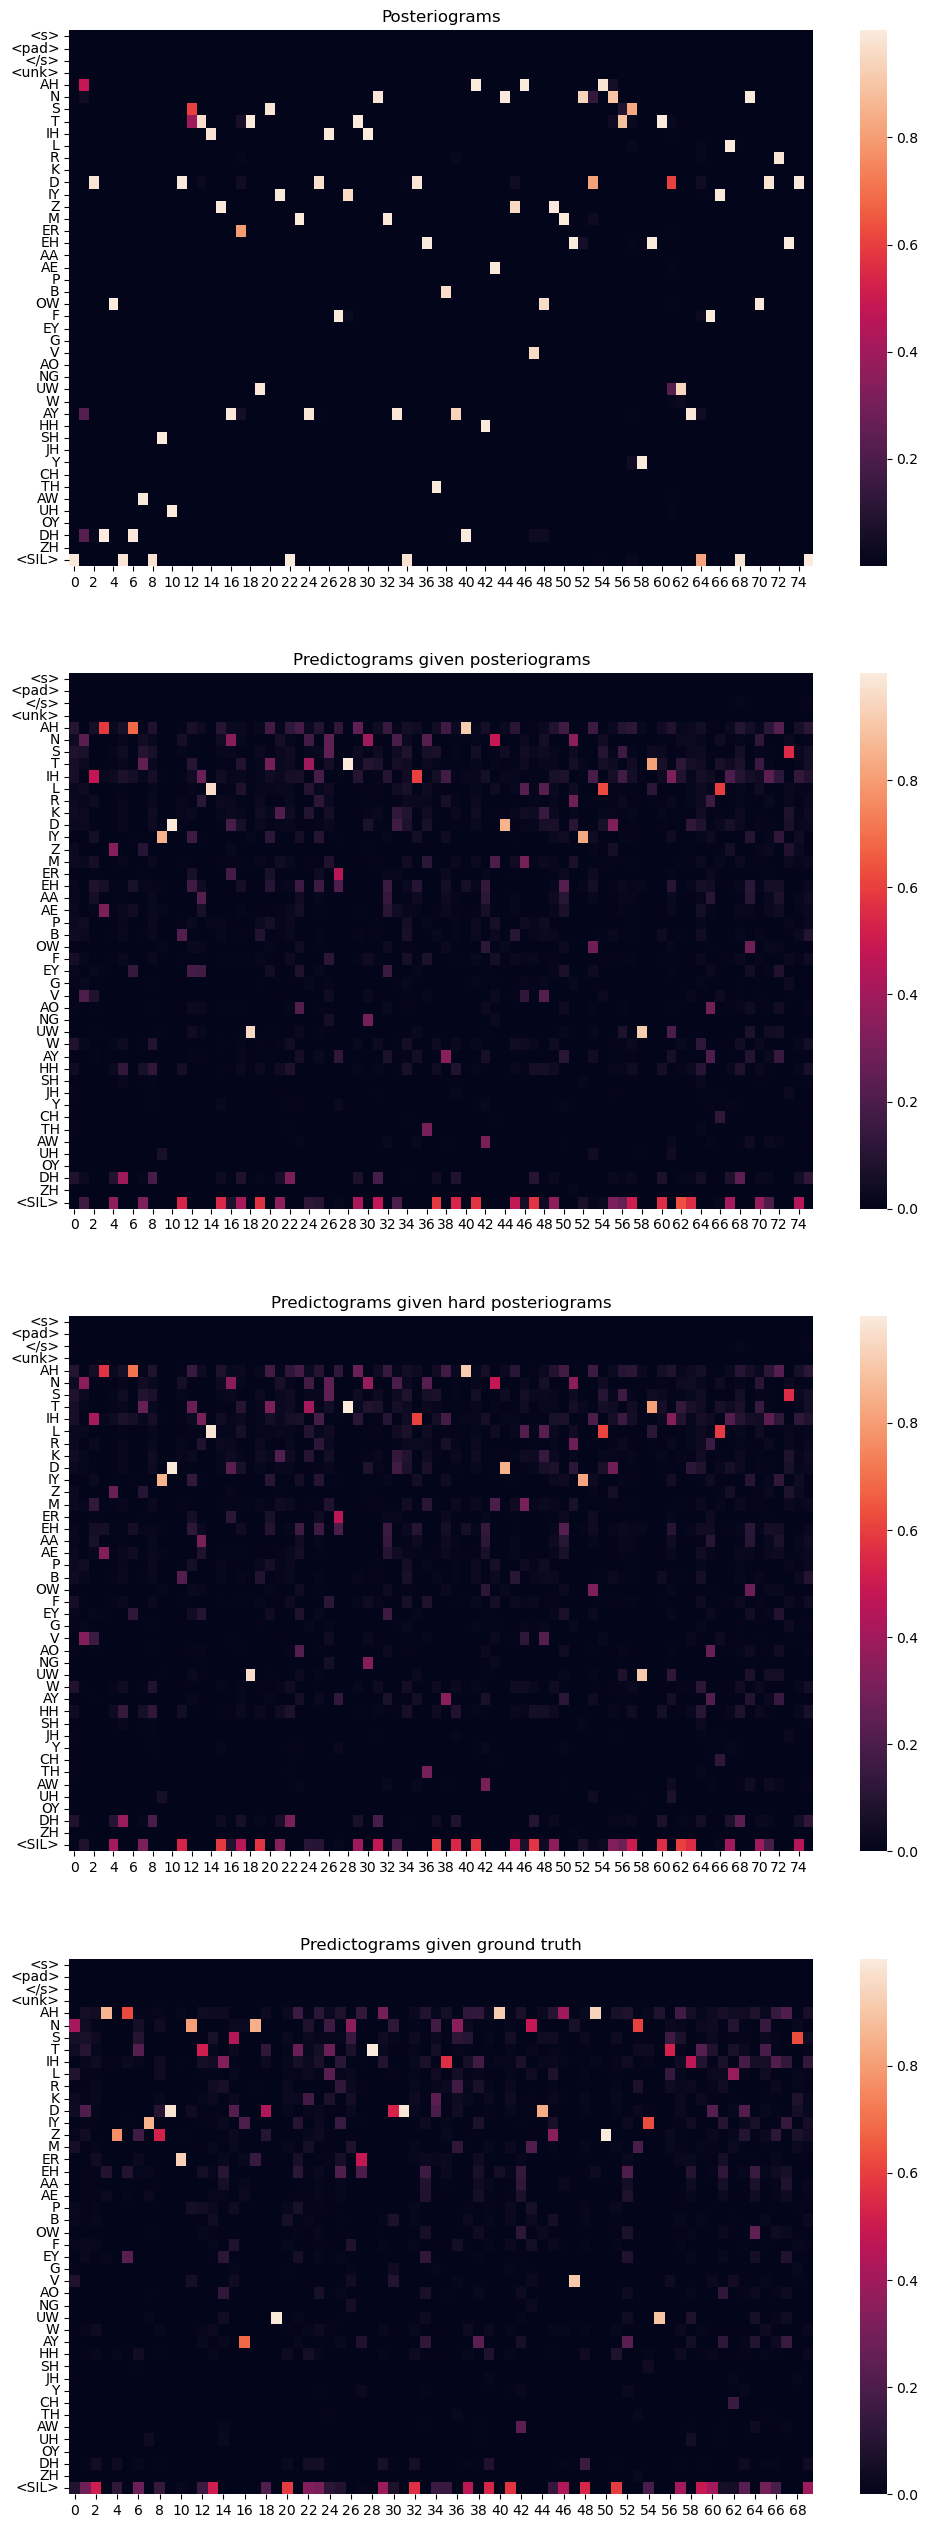

In [17]:
sample_idx = 0
x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
gen_result = wav2phn(x, padding_mask, dense_x_only=True)
dense_x = gen_result['logits']#[:, :, 4:]
predicted_x = dense_x.argmax(-1)# + 4
predicted_x = predicted_x[predicted_x != task.sil_id]
lm_post_gen = wav2dyn.lm(dense_x[:, :wav2dyn.block_size, :]).squeeze().detach().numpy().T
token_x = task.target_dictionary.encode_line(phone_transcripts[sample_idx][:-1], append_eos=False).long()# - 4
# token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float()
token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols)).unsqueeze(0).float()
lm_post_true = wav2dyn.lm(token_x[:, :wav2dyn.block_size, :]).squeeze().detach().numpy().T
# token_gen = F.one_hot(dense_x.argmax(-1), num_classes=len(task.target_dictionary.symbols) - 4).float()
token_gen = F.one_hot(dense_x.argmax(-1), num_classes=len(task.target_dictionary.symbols)).float()
lm_post_gen_hard = wav2dyn.lm(token_gen[:, :wav2dyn.block_size, :]).squeeze().detach().numpy().T
plt.figure(figsize=(12, 32))
plt.subplot(411)
# sns.heatmap(dense_x.squeeze().detach().numpy().T, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(dense_x.squeeze().detach().numpy().T, yticklabels=task.target_dictionary.symbols)
plt.title("Posteriograms")
plt.subplot(412)
# sns.heatmap(lm_post_gen, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(lm_post_gen, yticklabels=task.target_dictionary.symbols)
plt.title("Predictograms given posteriograms")
plt.subplot(413)
# sns.heatmap(lm_post_gen_hard, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(lm_post_gen_hard, yticklabels=task.target_dictionary.symbols)
plt.title("Predictograms given hard posteriograms")
plt.subplot(414)
# sns.heatmap(lm_post_true, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(lm_post_true, yticklabels=task.target_dictionary.symbols)
plt.title("Predictograms given ground truth")
print(f"Utterance:\n{phone_transcripts[sample_idx]}")
print(f"Predicted:\n{task.target_dictionary.string(predicted_x)}")

# wav2dyn outs

Utterance:
AH N D DH OW DH AW SH OW L D AH S T D IH Z AY ER T UW S IY M AY D IH F IY T AH N D M AY D EH TH B AY DH AH HH AE N D Z AH V DH OW Z M EH N Y EH T D UW AY F IY L N OW D R EH D

Predicted:
W AH V W AH V DH IH S F AO DH EH ER CH AH V DH AH W AA JH Z AH V L EY Z S EY W AA JH Z M AH N Z AH EH JH AH V IH NG T EY JH AH V F AA Z R AO W UH D Z AH N AH V P L EY Z AH L AY Z M EH N Z S TH AE Z


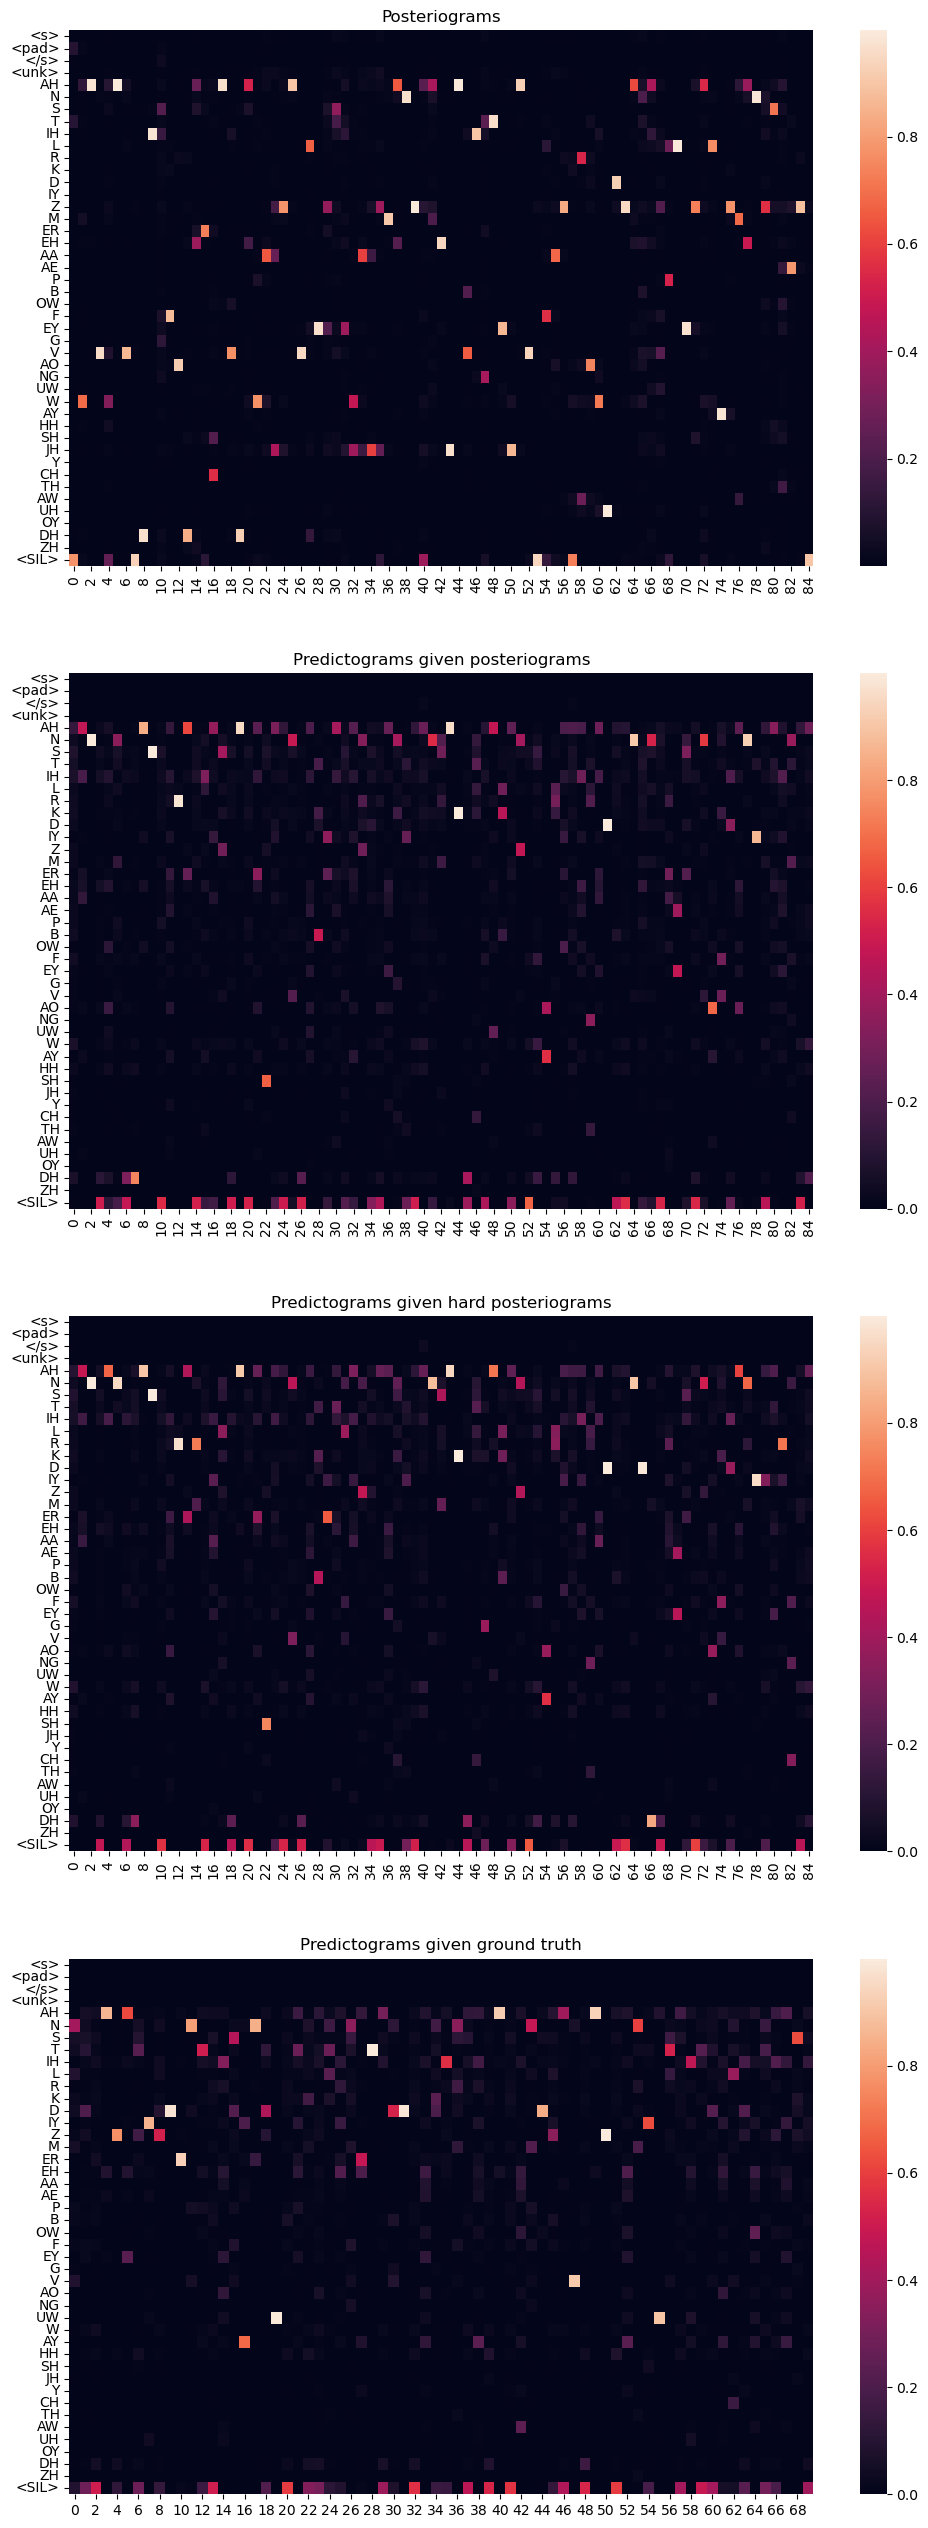

In [20]:
sample_idx = 0
x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
gen_result = wav2dyn(x, padding_mask, dense_x_only=True)
dense_x = gen_result['logits']#[:, :, 4:]
predicted_x = dense_x.argmax(-1)# + 4
predicted_x = predicted_x[predicted_x != task.sil_id]
lm_post_gen = wav2dyn.lm(dense_x[:, :wav2dyn.block_size, :]).squeeze().detach().numpy().T
token_x = task.target_dictionary.encode_line(phone_transcripts[sample_idx][:-1], append_eos=False).long()# - 4
# token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float()
token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols)).unsqueeze(0).float()
lm_post_true = wav2dyn.lm(token_x[:, :wav2dyn.block_size, :]).squeeze().detach().numpy().T
# token_gen = F.one_hot(dense_x.argmax(-1), num_classes=len(task.target_dictionary.symbols) - 4).float()
token_gen = F.one_hot(dense_x.argmax(-1), num_classes=len(task.target_dictionary.symbols)).float()
lm_post_gen_hard = wav2dyn.lm(token_gen[:, :wav2dyn.block_size, :]).squeeze().detach().numpy().T
plt.figure(figsize=(12, 32))
plt.subplot(411)
# sns.heatmap(dense_x.squeeze().detach().numpy().T, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(dense_x.squeeze().detach().numpy().T, yticklabels=task.target_dictionary.symbols)
plt.title("Posteriograms")
plt.subplot(412)
# sns.heatmap(lm_post_gen, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(lm_post_gen, yticklabels=task.target_dictionary.symbols)
plt.title("Predictograms given posteriograms")
plt.subplot(413)
# sns.heatmap(lm_post_gen_hard, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(lm_post_gen_hard, yticklabels=task.target_dictionary.symbols)
plt.title("Predictograms given hard posteriograms")
plt.subplot(414)
# sns.heatmap(lm_post_true, yticklabels=task.target_dictionary.symbols[4:])
sns.heatmap(lm_post_true, yticklabels=task.target_dictionary.symbols)
plt.title("Predictograms given ground truth")
print(f"Utterance:\n{phone_transcripts[sample_idx]}")
print(f"Predicted:\n{task.target_dictionary.string(predicted_x)}")

# Collecting ground truth statistics on wiki40b

In [21]:
from collections import Counter
import re

# Remove newline characters from each string
corpus = [sentence.strip() for sentence in wiki_transcripts]
# Concatenate all the strings in the list into a single string
text = ' '.join(corpus).replace('<SIL>', "")
# Tokenize the string into individual phonemes using regular expressions
tokens = re.findall(r'\b\w+\b|[^\w\s]', text)
# Calculate the frequency distribution of the phonemes
freq_dist = Counter(tokens)
# Print the 10 most common phonemes in the corpus
print(freq_dist.most_common(10))

[('AH', 6266820), ('N', 4825403), ('T', 3619099), ('IH', 3394388), ('R', 2962307), ('S', 2854374), ('D', 2162027), ('L', 2141331), ('K', 1834755), ('IY', 1773248)]


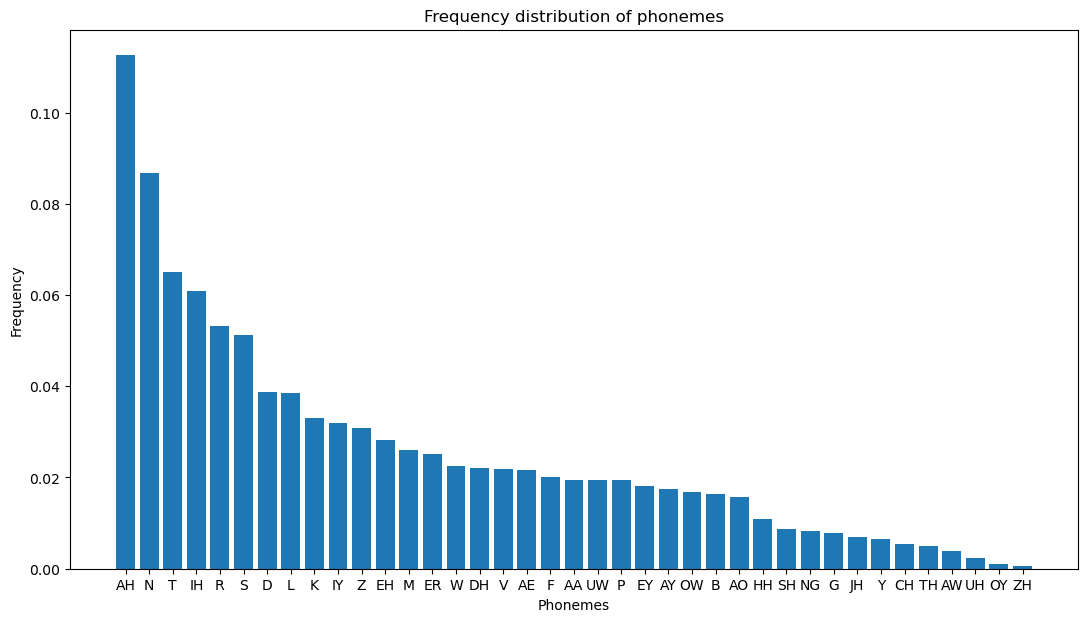

In [22]:
# Sort the frequency distribution in descending order of frequency
sorted_freq_dist = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)
# Extract the phoneme labels and frequencies into separate lists
labels, frequencies = zip(*sorted_freq_dist)
# Create a bar chart of the frequency distribution of all phonemes
plt.figure(figsize=(13, 7))
plt.bar(labels, frequencies / np.sum(frequencies))
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

# Collecting ground truth stats on val set

## Unigrams

In [23]:
from collections import Counter
import re

# Remove newline characters from each string
corpus = [sentence.strip() for sentence in phone_transcripts]
# Concatenate all the strings in the list into a single string
text = ' '.join(corpus)
# Tokenize the string into individual phonemes using regular expressions
tokens = re.findall(r'\b\w+\b|[^\w\s]', text)
# Calculate the frequency distribution of the phonemes
freq_dist = Counter(tokens)
# Print the 10 most common phonemes in the corpus
print(freq_dist.most_common(10))

[('AH', 17549), ('N', 12816), ('T', 12657), ('IH', 10532), ('D', 9316), ('S', 8822), ('R', 7659), ('L', 7019), ('IY', 6298), ('DH', 5663)]


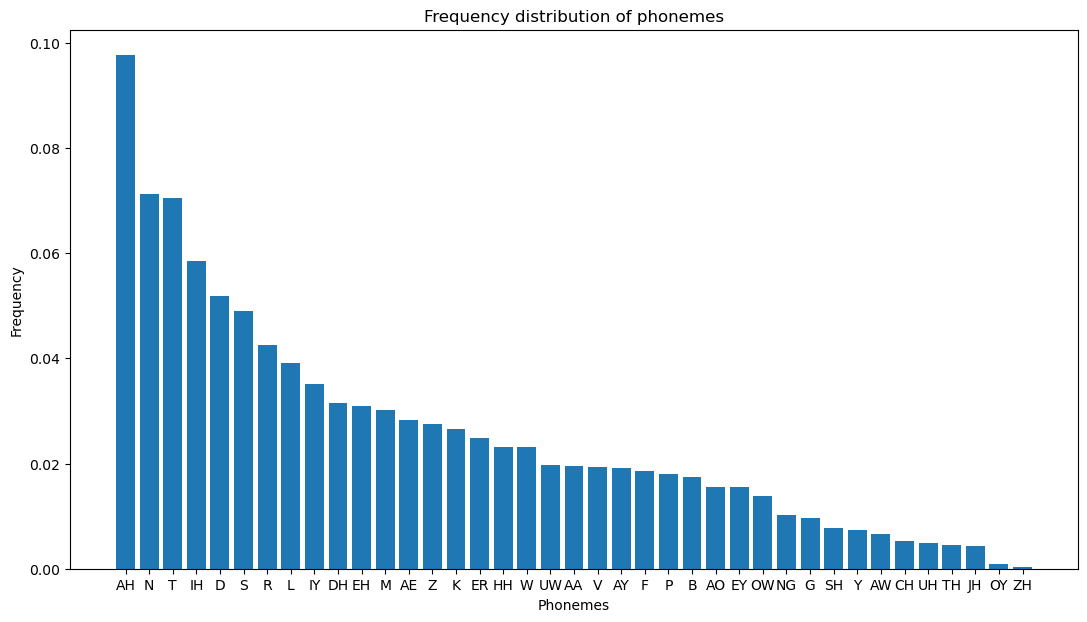

In [24]:
# Sort the frequency distribution in descending order of frequency
sorted_freq_dist = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)
# Extract the phoneme labels and frequencies into separate lists
labels, frequencies = zip(*sorted_freq_dist)
# Create a bar chart of the frequency distribution of all phonemes
plt.figure(figsize=(13, 7))
plt.bar(labels, frequencies / np.sum(frequencies))
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

## LM n-grams

In [25]:
posteriograms = []

for transcript in tqdm(phone_transcripts):
#     token_x = task.target_dictionary.encode_line(transcript[:-1], append_eos=False).long() - 4
    token_x = task.target_dictionary.encode_line(transcript[:-1], append_eos=False).long()
#     token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float()
    token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols)).unsqueeze(0).float()
    lm_post_true = wav2dyn.lm(token_x[:, :wav2dyn.block_size, :]).squeeze().detach().numpy()
    posteriograms.append(lm_post_true)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [26]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
# syms = task.target_dictionary.symbols[4:-1]
syms = task.target_dictionary.symbols[:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

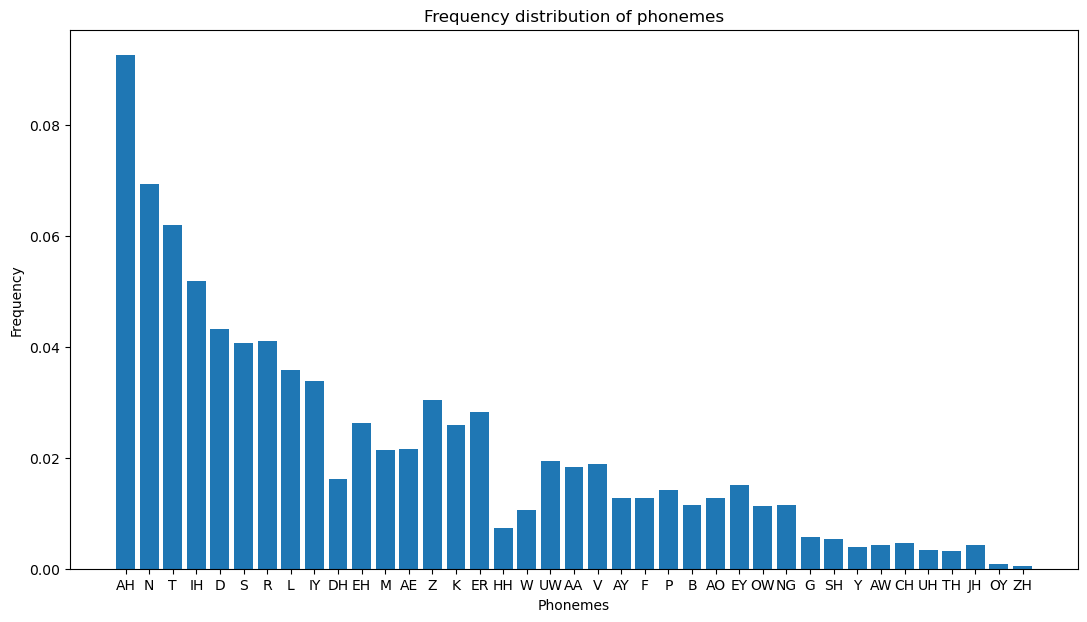

In [27]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

# Collecting stats on wav2phn after 2000 updates

In [28]:
posteriograms = []

for sample in tqdm(dataset):
    x = torch.FloatTensor(sample).unsqueeze(0)
    padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
    gen_result = wav2phn(x, padding_mask, dense_x_only=True)
#     dense_x = gen_result['logits'][:, :, 4:].squeeze().detach().numpy()
    dense_x = gen_result['logits'].squeeze().detach().numpy()
    posteriograms.append(dense_x)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [29]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
# syms = task.target_dictionary.symbols[4:-1]
syms = task.target_dictionary.symbols[:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

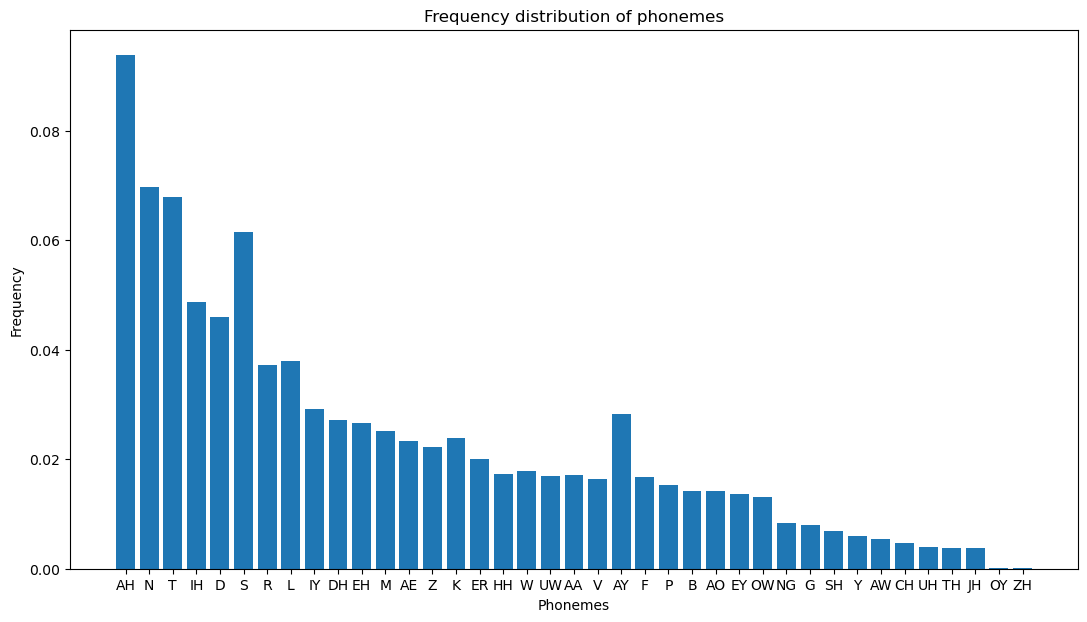

In [30]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

# Collecting stats on best wav2dyn after whole training

## On unigram posteriograms

In [31]:
posteriograms = []

for sample in tqdm(dataset):
    x = torch.FloatTensor(sample).unsqueeze(0)
    padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
    gen_result = wav2dyn(x, padding_mask, dense_x_only=True)
#     dense_x = gen_result['logits'][:, :, 4:].squeeze().detach().numpy()
    dense_x = gen_result['logits'].squeeze().detach().numpy()
    posteriograms.append(dense_x)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [32]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
# syms = task.target_dictionary.symbols[4:-1]
syms = task.target_dictionary.symbols[:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

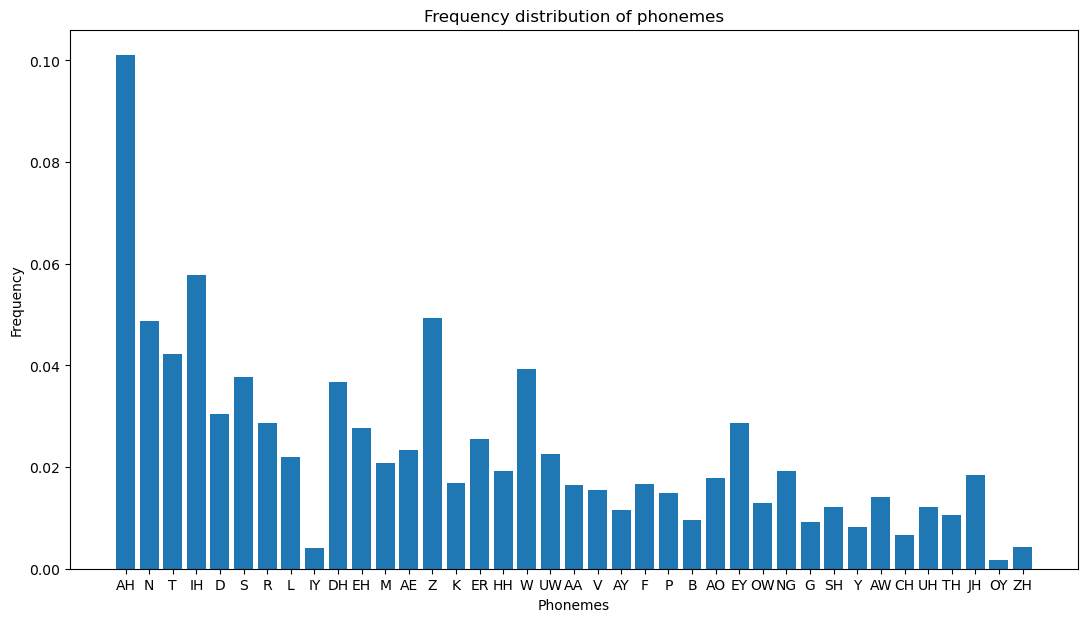

In [33]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

## On LM n-gram posteriograms

In [34]:
posteriograms = []

for sample in tqdm(dataset):
    x = torch.FloatTensor(sample).unsqueeze(0)
    padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
    gen_result = wav2dyn(x, padding_mask, dense_x_only=True)
#     dense_x = gen_result['logits'][:, :, 4:]
    dense_x = gen_result['logits']
    lm_post_gen = wav2dyn.lm(dense_x[:, :wav2dyn.block_size, :]).squeeze().detach().numpy()
    posteriograms.append(lm_post_gen)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [35]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
# syms = task.target_dictionary.symbols[4:-1]
syms = task.target_dictionary.symbols[:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

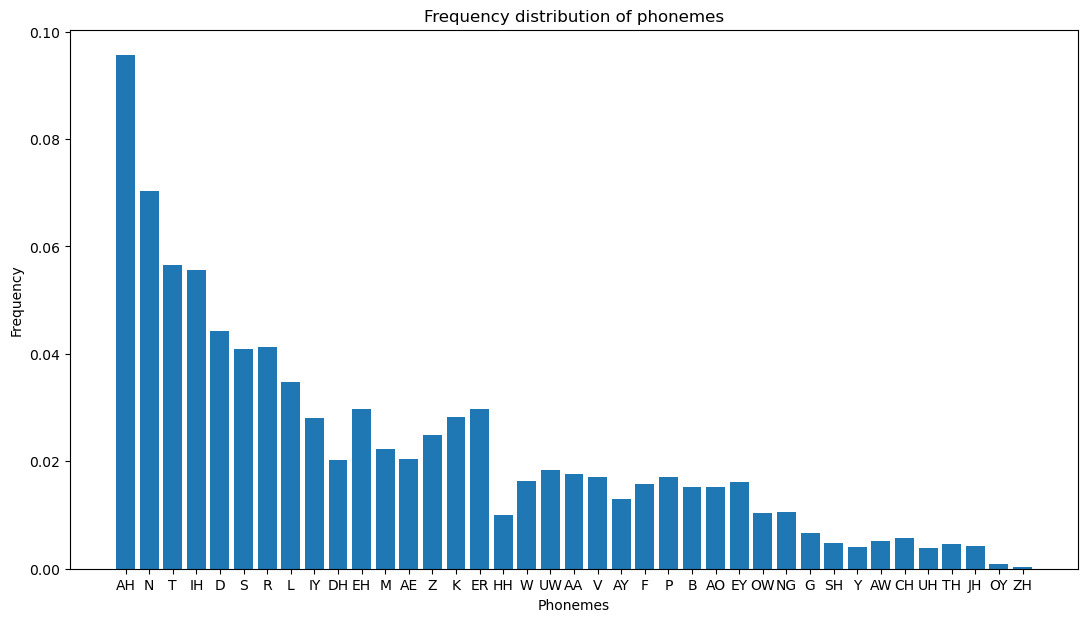

In [36]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

# Collecting stats for random input sequences to LM

In [47]:
posteriograms = []

for transcript in tqdm(phone_transcripts):
    seq_len = random.randint(31, 128)
    token_x = torch.randint(0, len(task.target_dictionary.symbols) - 4, (seq_len,))
    token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float()
    lm_post_true = wav2dyn.lm(token_x[:, :wav2dyn.block_size, :]).squeeze().detach().numpy()
    posteriograms.append(lm_post_true)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [44]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
# syms = task.target_dictionary.symbols[4:-1]
syms = task.target_dictionary.symbols[:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

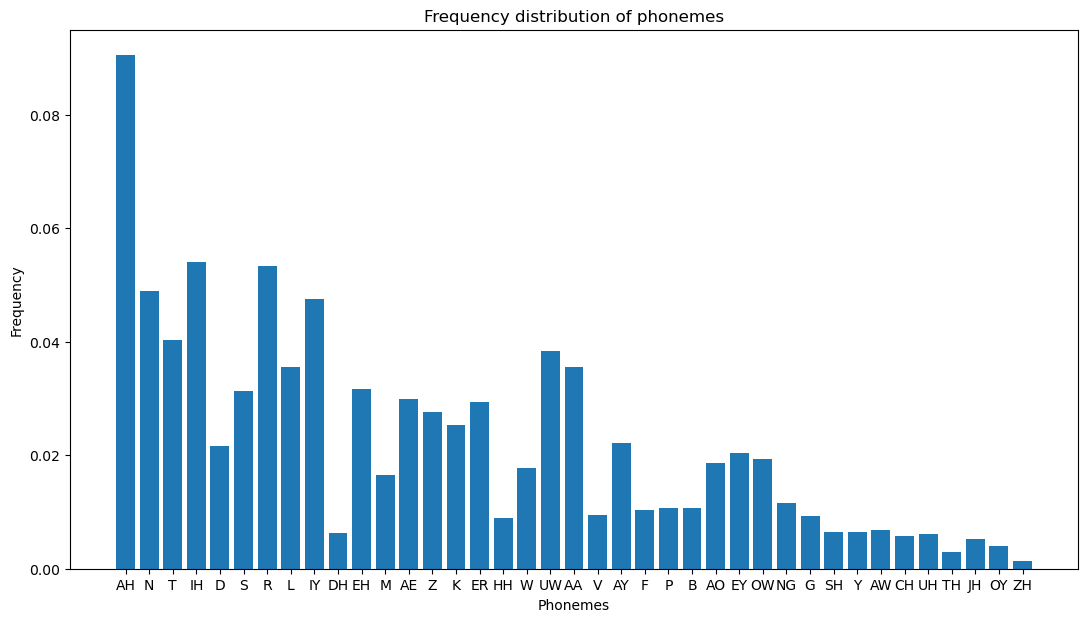

In [45]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()